In [1]:
from IPython.display import Markdown, display
display(Markdown(open("./SM_header.md", "r").read()))

Copyright © 2025 Université Paris Cité

Author: [Guillaume Rousseau](https://www.linkedin.com/in/grouss/), Laboratoire Matières et Systèmes Complexes, UMR 7057, CNRS and Université Paris Cité, CNRS, UMR7057, 10 rue Alice Domon et Léonie Duquet, F-75013, Paris cedex 13, France (email: guillaume.rousseau@u-paris.fr)

This archive contains the supplemental materials and replication package associated with the preprint, "*Growth Regime Shifts in Empirical Networks: Evidence and Challenges from the Software Heritage and APS Citation Case Studies*", available on [arXiv](https://arxiv.org/abs/2501.10145) and [ssrn](http://ssrn.com/abstract=5191689).

**The latest version of the preprint (timestamped arXiv:2501.10145v4) is downloadable here https://arxiv.org/pdf/2501.10145**

The current version of the Python scripts and associated resources is available on the [author's GitHub page](https://github.com/grouss/growing-network-study).

This work is currently licensed under the [Creative Commons CC BY-NC-SA 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0).

To give appropriate credit and cite this work ([BibTeX entry](./rousseau2025temporal)):
Rousseau, G. (2025). *Growth Regime Shifts in Empirical Networks: Evidence and Challenges from the Software Heritage and APS Citation Case Studies* [Preprint]. arXiv:2501.10145. https://arxiv.org/abs/2501.10145; also available on SSRN: http://ssrn.com/abstract=5191689

 
# A) Replication Packages

[Open the Replication Package notebook related to the datasets.](./Replication_Package_Datasets.ipynb)

[Open the Replication Package notebook related to the figures.](./Replication_Package_Figures.ipynb)

# B) QuickStart Guide

[Open the QuickStart Guide notebook](./SM00_QuickStart.ipynb)

# C) Table of Contents

- 1. [Function Definitions](./SM01_Functions.ipynb)
- 2. [Dataset Import](./SM02_DatasetImport.ipynb)
- 3. [Building the Transposed Graph](./SM03_BuildingTransposedGraph.ipynb)
- 4. [Temporal Information Quality and Summary Statistics](./SM04_TemporalInformationMainStats.ipynb)
- 5. [Growth Relationship Between Nodes and Edges](./SM05_GrowingRules.ipynb)
- 6. [Topological Partitioning($RV$ Nodes)](./SM06_TopologicalPartitioning.ipynb)
- 7. [In-Degree and Out-Degree Distributions Over Time](./SM07_DegreeDistributionOverTime.ipynb)
- 8. [Distribution Tail Analysis](./SM08_DistributionTailAnalysis.ipynb)
- 9. [Temporal Partitioning](./SM09_TemporalPartitioning.ipynb)
- 10. [Derived $O-(RV/RL)-O$ Graph Construction](./SM10_DerivedGrowingNetwork.ipynb)
- 11. [Building the $TSL$ Partitioning](./SM11_TSLPartitioning.ipynb)
- 12. [Price / Directed Barabási–Albert Model Use Case](./SM12_BarabasiAlbertUseCase.ipynb)
- 13. [APS citation network](./SM13_APSCitationNetwork.ipynb)
- 14. [Generic Report Template](./SM14_GenericReport.ipynb)


**NB :** As of 2025/09/15, the QuickStart guide, the replication packages, and SM01 to SM14 are available. The Python scripts are also provided under `local_utils` directory, but they are not in their final form and should be considered an alpha release. 

The main graph datasets used in the study are available in a distinct Zenodo Deposit 10.5281/zenodo.15260640 ($\sim50$ Go), including the main dataset $O/RV/RL-O/RV/RL$ (2+ billions of nodes, $\sim4$ billions of edges), and two derived $O-(RV/RL)-O$ graphs ($\sim150$ millions nodes and edges).

The APS Citation Dataset (2022 export) has been included in the study.

More release notes are available in the [dedicated notebook](./SM_ReleaseNote.ipynb).

In [2]:
%load_ext autoreload
%autoreload 2

import importlib,sys,local_utils
from local_utils import *

print("___ Import data from graphpath=",config.graphpath)
print("___ Export data to exportpath=",config.exportpath)   

DisplayCopyrightInfo()


___ Import data from graphpath= ./ImportData/
___ Export data to exportpath= ./ExportData/
--------------------------------------------------------------------------------
Copyright 2025 Université Paris Cité, France 
Author: Guillaume Rousseau, MSC Lab, Physics Department, Paris, France 

(https://www.linkedin.com/in/grouss/)

This archive contains the supplemental materials and replication package associated with the preprint available on :
- arXiv (https://arxiv.org/abs/2501.10145)
- SSRN  (http://ssrn.com/abstract=5191689

Current version of python scripts and associated ressources are available on author's github page
(https://github.com/grouss/growing-network-study)

This work is currently licensed under CC BY-NC-SA 4.0
(https://creativecommons.org/licenses/by-nc-sa/4.0)
--------------------------------------------------------------------------------



---

# 7 Indegree and Outdegree Distribution Over Time

For simplicity, we use the timestamp of the source node as the creation timestamp of an edge, though this can easily be generalized to other rules.

In the general case, when discussing the number of outgoing degrees, it is important to account for the different types of edges emerging from the same source node, distinguishing them based on the types of target nodes they point to.

The distributions of incoming degrees can be easily (and efficiently) obtained from the transposed derived graph. Here, no specific performance issues arise, and we propose an implementation that processes both incoming and outgoing degrees simultaneously from the derived graph.

For each type of source node and edge type, we will distinguish between marginal distributions and the global distribution, which is simply, for a given node type, the distribution of outgoing or incoming degrees without regard to the type of target node —i.e., the sum of the degrees associated with each edge type.

In the general case, these variables are not independent, and the global distribution is not simply given by the convolution product of the marginal distributions. Nevertheless, as we shall see later, failing to distinguish between edge types can hide certain features of the marginal distributions, particularly when one type dominates the others.

When at least one of the nodes has a timestamp, or when edges have their own timestamps, it becomes possible to study the temporal evolution of these distributions.

In cases where multiple timestamps exist, as is the case in the current study, we must examine the effect this has on these distributions.

## a) Building statistic per months

In [3]:
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray()   


Loaded : ./ImportData/nodes_20240310.pkl
Loaded : ./ImportData/edges_20240310.pkl
Loaded : ./ImportData/nodesad_20240310.pkl
Loaded : ./ImportData/d_20240310.pkl
DatasetName SWH derived (O/RL/RV)-(RL/RV)
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01


In [4]:
ti=time.time()
Edgestype,Edgesencoding=GetEdgesTypesArray(nodes,edges,d=d)
Nodestype,Nodesencoding=GetNodesTypesArray(nodes,edges,d)
tf=time.time()
print("Node and Edge Type Building ",np.round(tf-ti,2),"(s)")

Node and Edge Type Building  20.6 (s)


In [5]:
print(Edgesencoding)
ti=time.time()
count=np.bincount(Edgestype,minlength=len(Edgesencoding))
tf=time.time()
print("Count Type elapse : ",np.round(tf-ti,2),"(s)")
for indextype,edgeType in enumerate(Edgesencoding):
    print(f'___ {edgeType:6} {count[indextype]:,}')
if np.sum(count)==Nedges:
    print(f'All {np.sum(count):,} (ok if ==) {Nedges:,} => OK')
else:
    print(f'All {np.sum(count):,} (ok if ==) {Nedges:,} => NOT OK')
    


['O>O', 'O>RL', 'O>RV', 'RL>O', 'RL>RL', 'RL>RV', 'RV>O', 'RV>RL', 'RV>RV']
Count Type elapse :  14.2 (s)
___ O>O    0
___ O>RL   687,095,698
___ O>RV   1,017,960,393
___ RL>O   0
___ RL>RL  41,351
___ RL>RV  17,225,899
___ RV>O   0
___ RV>RL  0
___ RV>RV  2,119,355,702
All 3,841,679,043 (ok if ==) 3,841,679,043 => OK


In [6]:
ti=time.time()
sourceedges=GetSourceEdge(nodes,Nedges)
sourceType=Nodestype[sourceedges]
sourceTSY=timestampsarray2yearmonth(GetSourceEdgeTimeStamp(nodes,edges,nodesad,d))//12
tf=time.time()
print("Source Type and TimesTamp Building elapse : ",np.round(tf-ti,2),"(s)")
# Source Type and TimesTamp Building elapse :  76.58 (s) (on a MacStudio M2)

Source Type and TimesTamp Building elapse :  82.87 (s)


In [7]:
ti=time.time()
targetType=Nodestype[edges]
targetTSY=timestampsarray2yearmonth(GetTargetEdgeTimeStamp(nodes,edges,nodesad,d))//12
tf=time.time()
print("Target Type and TimesTamp Building elapse : ",np.round(tf-ti,2),"(s)")
# Target Type and TimesTamp Building elapse :  103.1 (s) (on a MacStudio M2)

Target Type and TimesTamp Building elapse :  103.8 (s)



**Comment**: In this study, we assign the `targetTSY` timestamp to the `sourceTSY` field for origin nodes. The present approach implicitly assumes that the outgoing edges from an origin node become effective at the creation time of their respective target nodes.

Alternative propagation rules may be relevant depending on the analytical context. In particular, once a temporal partitioning is applied, it may be possible to infer an explicit appearance date for at least a subset of origin nodes (see SM09 and SM10 for further details). 


In [8]:
sourceTSY[:nodes[d["OindexMax"]+1]]=targetTSY[:nodes[d["OindexMax"]+1]]

In [9]:
# assumes that degreeInOutHisto_year_1980_2025_20240924.pkl exists
Rebuild=False
Fsave=False
version="20250524" # filename version for degreeInOutHisto

In [10]:
if Rebuild:
    dout={}
    din={}

In [15]:
if Rebuild:
    GetAllTypesDegreeStats(sourceedges,edges,sourceTSY,dout,din,Nnodes)   
    #All types elapse :  1618.31 (s) (on a Mac Studio M2)

Start All types
1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
All types elapse :  1618.31 (s)


In [16]:
if Rebuild:
    GetPerTypesDegreeStats(sourceedges,edges,sourceTSY,Edgestype,Edgesencoding,dout,din,Nnodes,PerFlag="EDGE")   

Start Per EDGE types 
Start type O>RL / 687,095,698 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type O>RV / 1,017,960,393 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RL>RL / 41,351 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RL>RV / 17,225,899 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RV>RV / 2,119,355,702 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Per edges types elapse :  4675.58 (s)


In [17]:
if Rebuild:
    GetPerTypesDegreeStats(sourceedges,edges,sourceTSY,Edgestype,Edgesencoding,dout,din,Nnodes,PerFlag="SOURCE")  

Start Per SOURCE types 
Start type O> / 1,705,056,091 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RL> / 17,267,250 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RV> / 2,119,355,702 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Per edges types elapse :  3226.27 (s)


In [18]:
if Rebuild:
    GetPerTypesDegreeStats(sourceedges,edges,sourceTSY,Edgestype,Edgesencoding,dout,din,Nnodes,PerFlag="TARGET")   


Start Per TARGET types 
Start type >RL / 687,137,049 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type >RV / 3,154,541,994 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Per edges types elapse :  2452.07 (s)


In [21]:
if Fsave:
    pickle.dump((dout,din),open(exportpath+"degreeInOutHisto_year_1980_2025_"+version+".pkl","wb"))

## b) Integrity check of the in/out degree histogram 

As a consistency check, one may verify that the histograms computed for individual subtypes, when aggregated, match those obtained directly for the corresponding higher-level categories.


In [11]:
# check din vs dout stats
# din[*][*]["ccdf"][0]==din[*][*]["ccdf"][0]
# np.sum(din[*][*]["x"]*din[*][*]["y"])==np.sum(dout[*][*]["x"]*dout[*][*]["y"])
version="20250524"
for filename in ["degreeInOutHisto_year_1980_2025_"+version+".pkl","degreeInOutHisto_year_1980_2025_"+version+".pkl"]:
    print("LOAD ",filename)
    dout,din=pickle.load(open(exportpath+filename,"rb"))
    print(dout.keys())
    print(din.keys())
    for key in ['All types','O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV','RL>','>RL','O>']:
        print("-"*80)
        print(key, end=" ")
        error=0
        for year in din[key].keys():
            if year in din[key] and year in dout[key]:
                # check 1 : din[*][*]["ccdf"][0]==din[*][*]["ccdf"][0]
                if len(din[key][year]["ccdf"])!=0:
                    if din[key][year]["ccdf"][0]!=dout[key][year]["ccdf"][0]:
                        print("___ Check 1 Error | year",year,
                              'din[key][year]["ccdf"][0]',din[key][year]["ccdf"][0],
                              'dout[key][year]["ccdf"][0]',dout[key][year]["ccdf"][0],
                              'delta',din[key][year]["ccdf"][0]-dout[key][year]["ccdf"][0]
                             )
                        error+=1
                    else:
                        pass
                        #print("___ year",year,"ok")
                # check 2 : np.sum(din[*][*]["x"]*din[*][*]["y"])==np.sum(dout[*][*]["x"]*dout[*][*]["y"])
                    if np.sum(din[key][year]["x"]*din[key][year]["y"])!=np.sum(dout[key][year]["x"]*dout[key][year]["y"]):
                        print("___ Check 2 Error : year ",year,"key",key,np.sum(din[key][year]["x"]*din[key][year]["y"]),
                              np.sum(dout[key][year]["x"]*dout[key][year]["y"]))
                        error+=1
                else:
                    print("___ missing data, key",key,"year",year,"len",len(din[key][year]["ccdf"]))
                    error+=1
            else:
                print("___ missing year",year, "key",key,"check",year in din,year in dout)
                error+=1
        # check 3 : year==3000 exists => All years (ie check stats are uptodate / stat.py
        if 3000 not in din[key] or 3000 not in dout[key]:
            print("___ missing 3000 (all years) in key=",key,"check", 3000 in din[key], 3000 in dout[key])
            error+=1
        if error==0:
            print("ok")
    # check 4 : check that aggregated stats are ok 
    # 'All types' must be equal to sum of 'O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV'
    for list_key_1,list_key_2 in [
        (['All types'],['O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV']),
        (['O>'],['O>RV', 'O>RL']),
        (['RL>'],['RL>RV', 'RL>RL']),
        (['RV>'],['RV>RV']),
        (['>RL'],['O>RL', 'RL>RL']),
        (['>RV'],['RL>RV','RV>RV','O>RV']),
    ]:
        print("-"*80)
        print(list_key_1,list_key_2,end=" ")
        #print("-"*80)
        error=0

        # cumulative sum over year
        for degree,field in [(dout,"dout"),(din,"din")]:
            sumedges_1=0
            for key_1 in list_key_1:
                for year in din[key_1].keys():
                    sumedges_1+=np.sum(degree[key_1][year]["x"]*degree[key_1][year]["y"])
            sumedges_2=0
            for key_2 in list_key_2:
                for year in din[key_2].keys():
                    sumedges_2+=np.sum(degree[key_2][year]["x"]*degree[key_2][year]["y"])
            if sumedges_1!=sumedges_2:
                print("___ Error","field",field,"sumedges_1",sumedges_1,"sumedges_2",sumedges_2)
                error+=1
        if error==0:
            print("ok")

    print("-"*80)


LOAD  degreeInOutHisto_year_1980_2025_20250524.pkl
dict_keys(['All types', 'O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV', 'O>', 'RL>', 'RV>', '>RL', '>RV'])
dict_keys(['All types', 'O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV', 'O>', 'RL>', 'RV>', '>RL', '>RV'])
--------------------------------------------------------------------------------
All types ok
--------------------------------------------------------------------------------
O>RL ok
--------------------------------------------------------------------------------
O>RV ok
--------------------------------------------------------------------------------
RL>RL ok
--------------------------------------------------------------------------------
RL>RV ok
--------------------------------------------------------------------------------
RV>RV ok
--------------------------------------------------------------------------------
RL> ok
--------------------------------------------------------------------------------
>RL ok
---------------------------

## c) Displaying Yearly Histograms by Type

dout.keys() dict_keys(['All types', 'O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV', 'O>', 'RL>', 'RV>', '>RL', '>RV'])
din.keys()  dict_keys(['All types', 'O>RL', 'O>RV', 'RL>RL', 'RL>RV', 'RV>RV', 'O>', 'RL>', 'RV>', '>RL', '>RV'])
--------------------------------------------------------------------------------


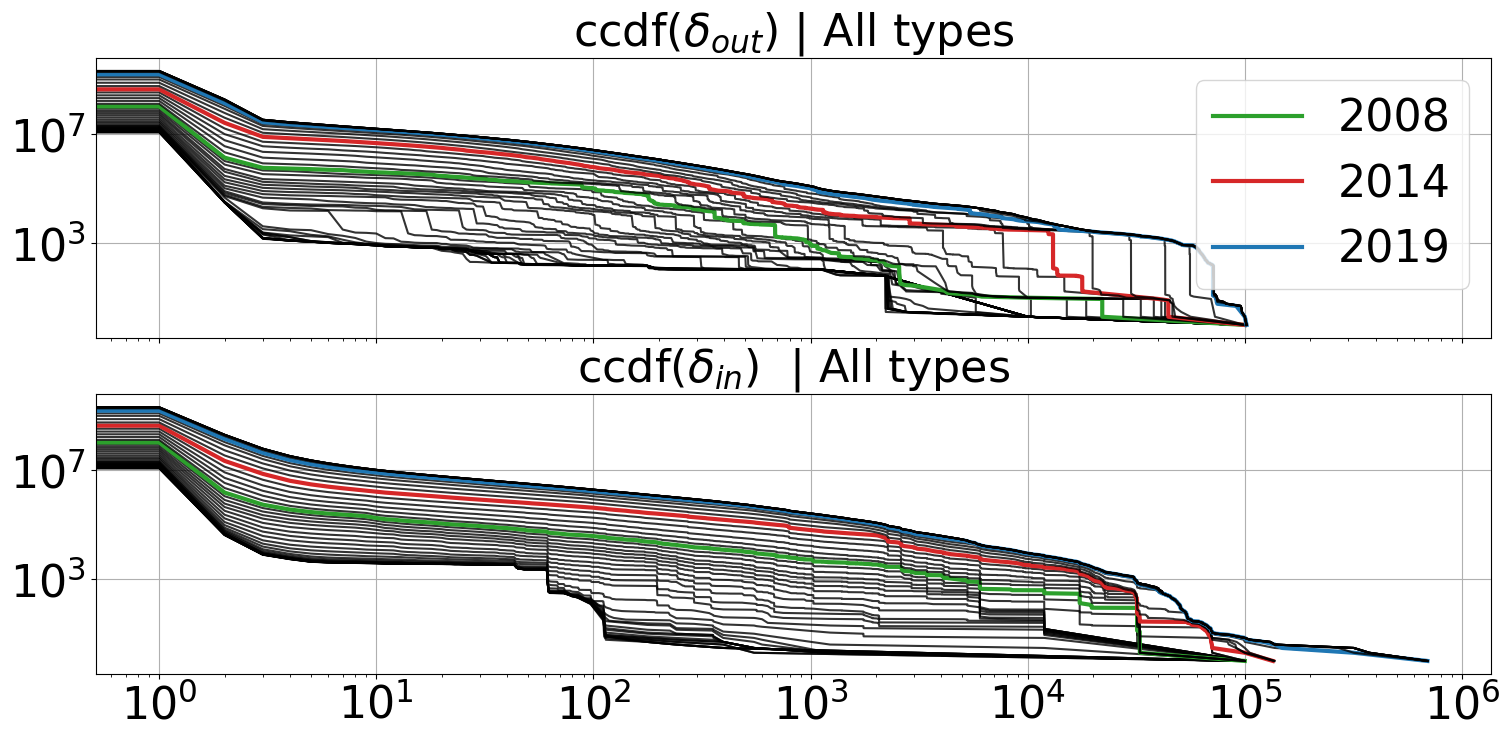

--------------------------------------------------------------------------------


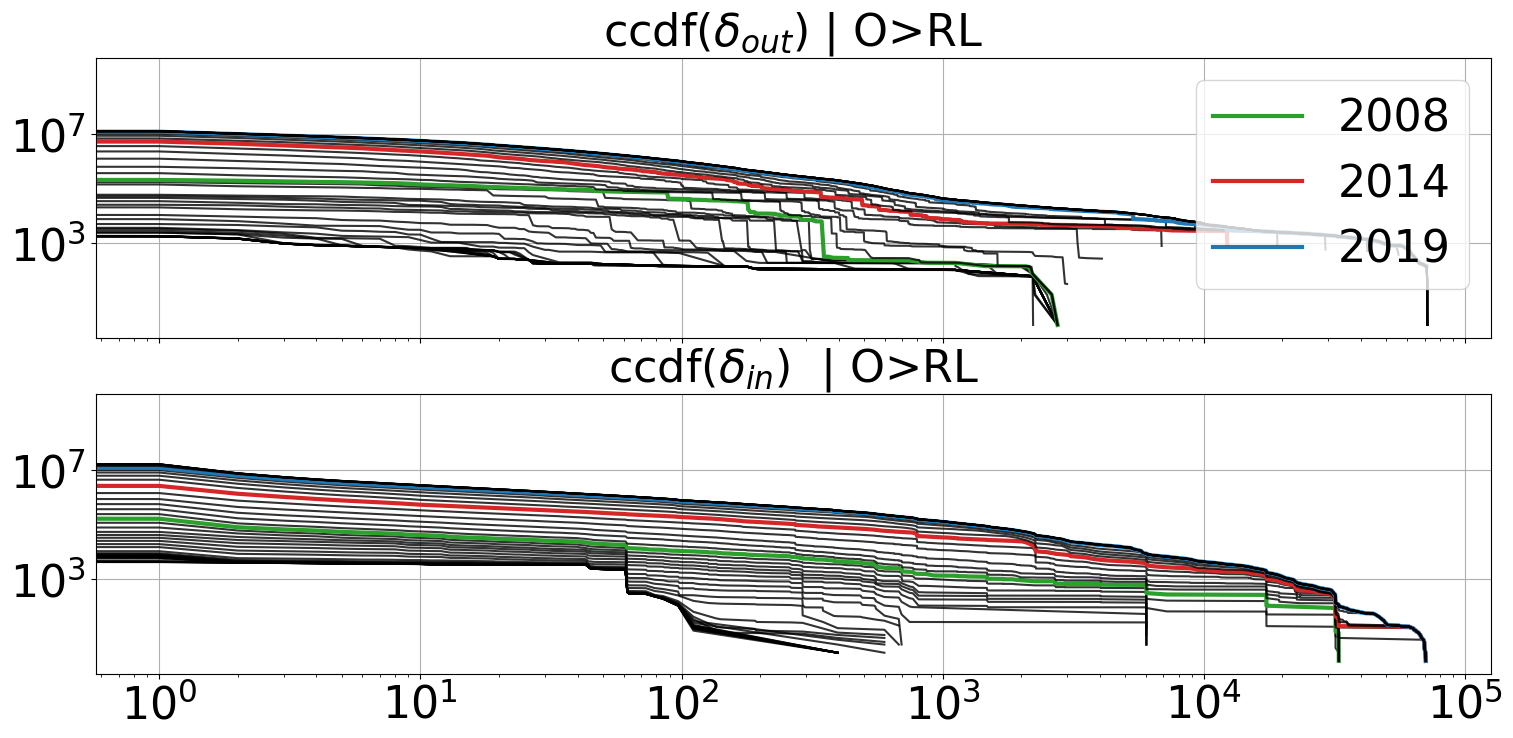

--------------------------------------------------------------------------------


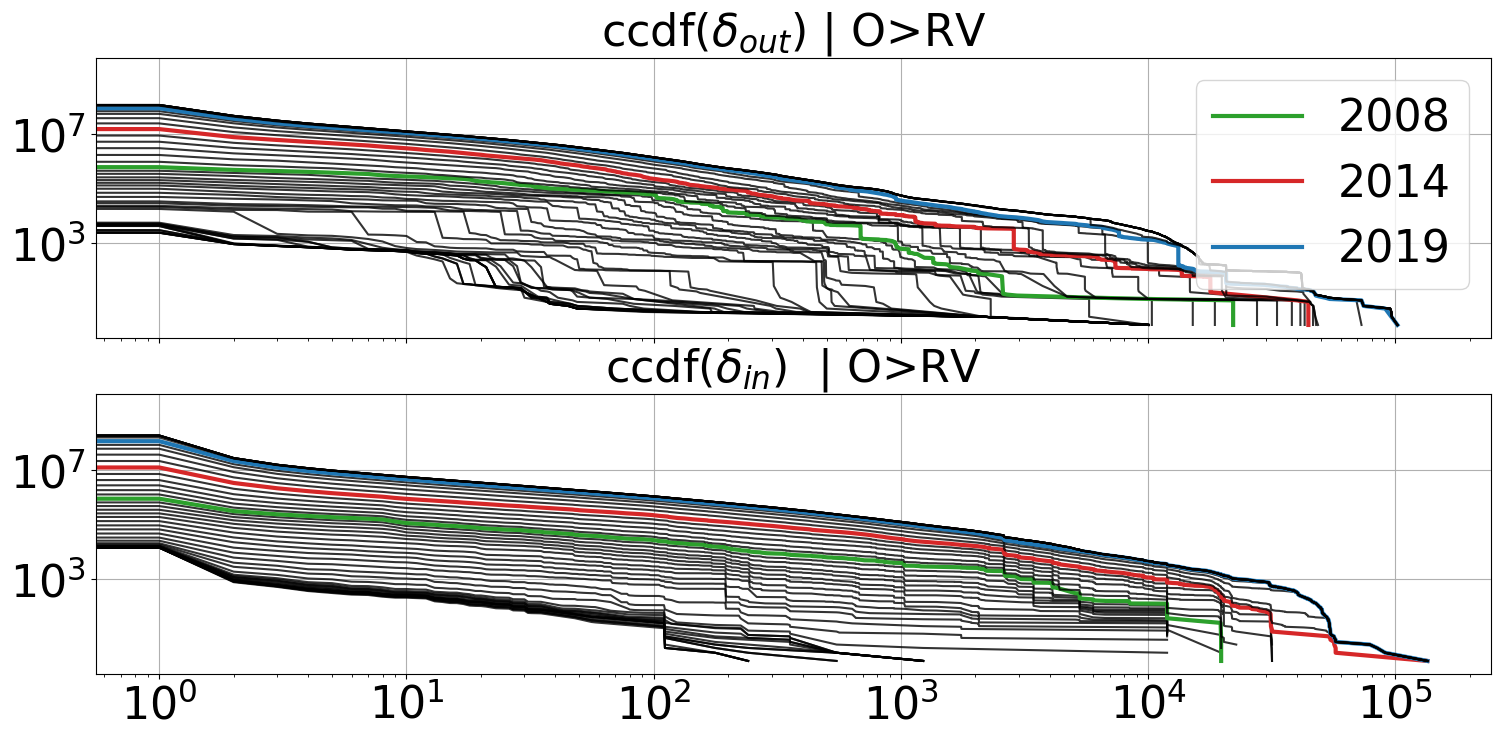

--------------------------------------------------------------------------------


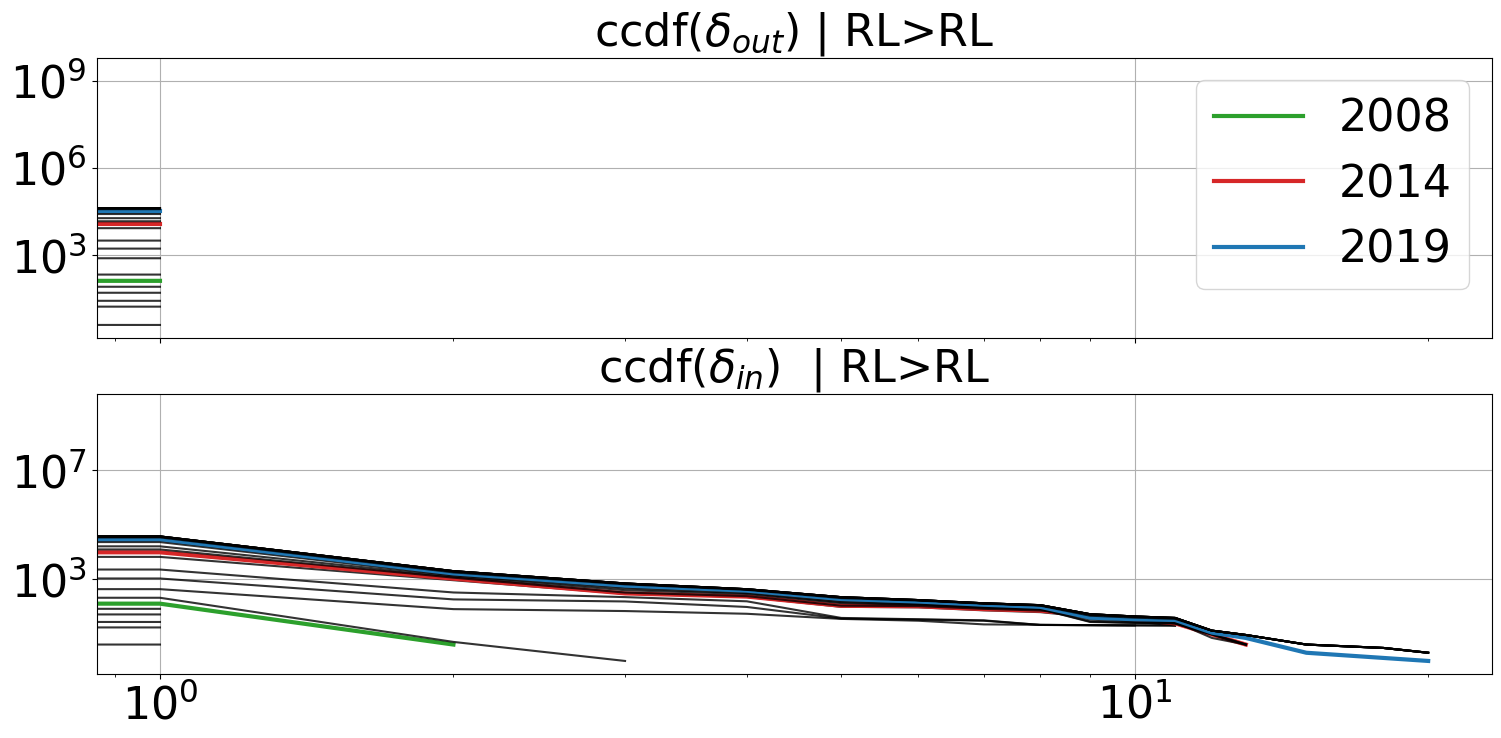

--------------------------------------------------------------------------------


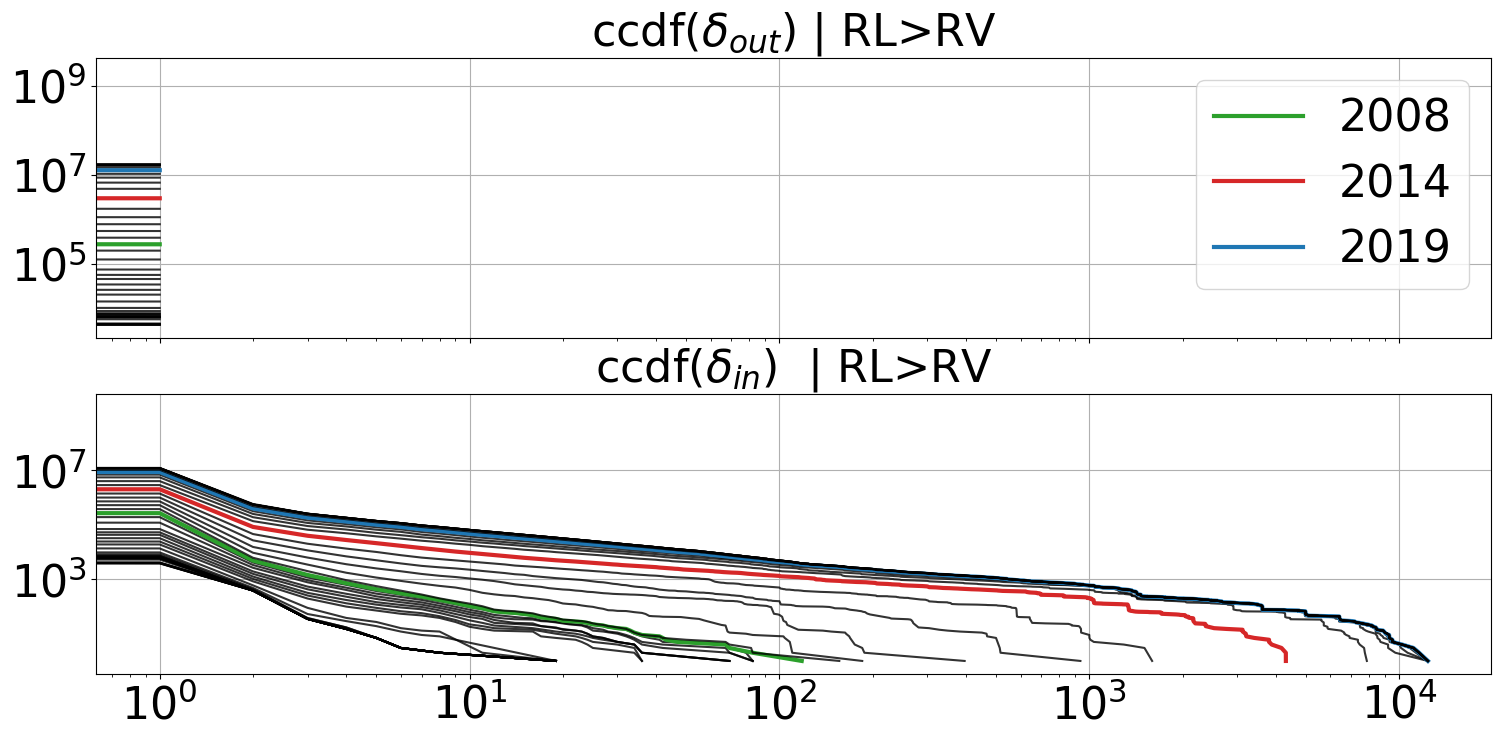

--------------------------------------------------------------------------------


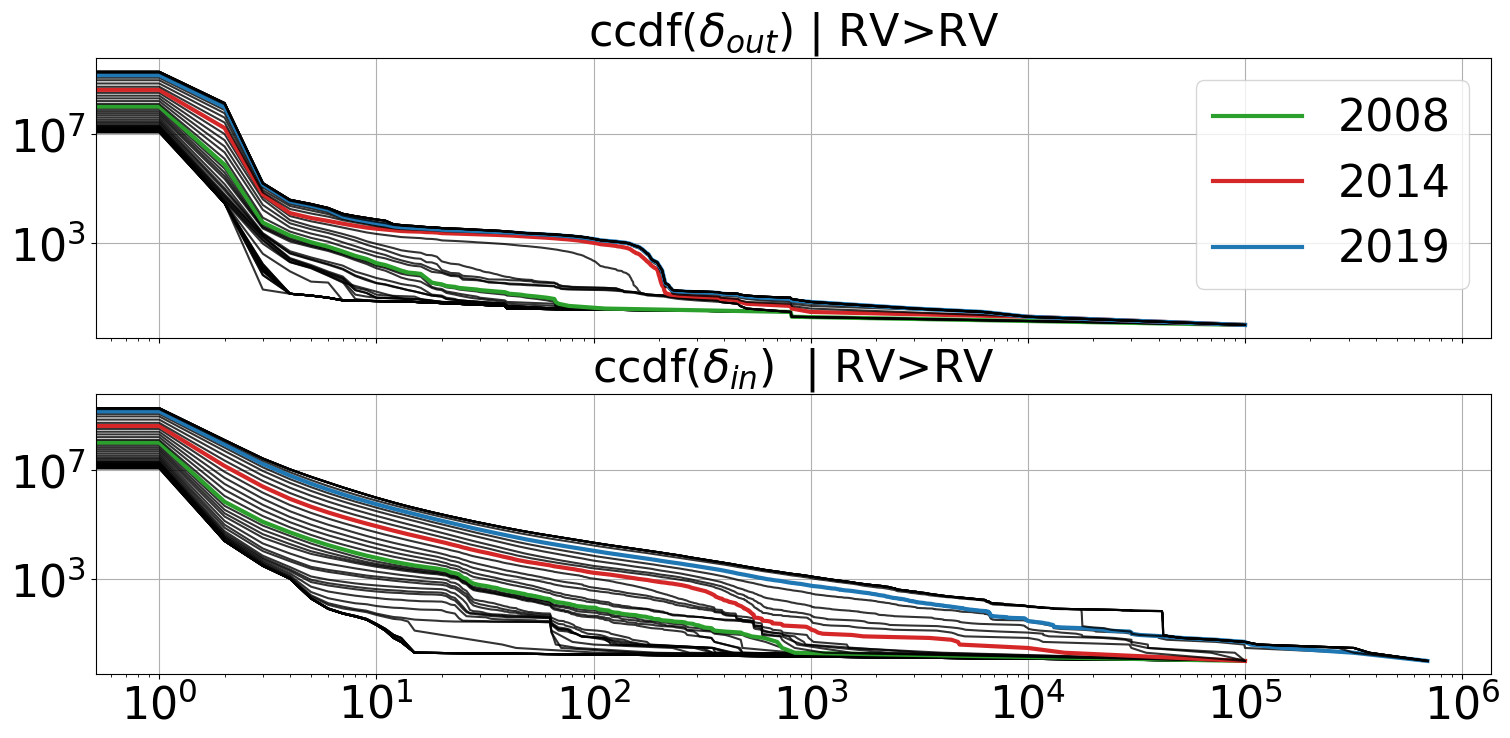

--------------------------------------------------------------------------------


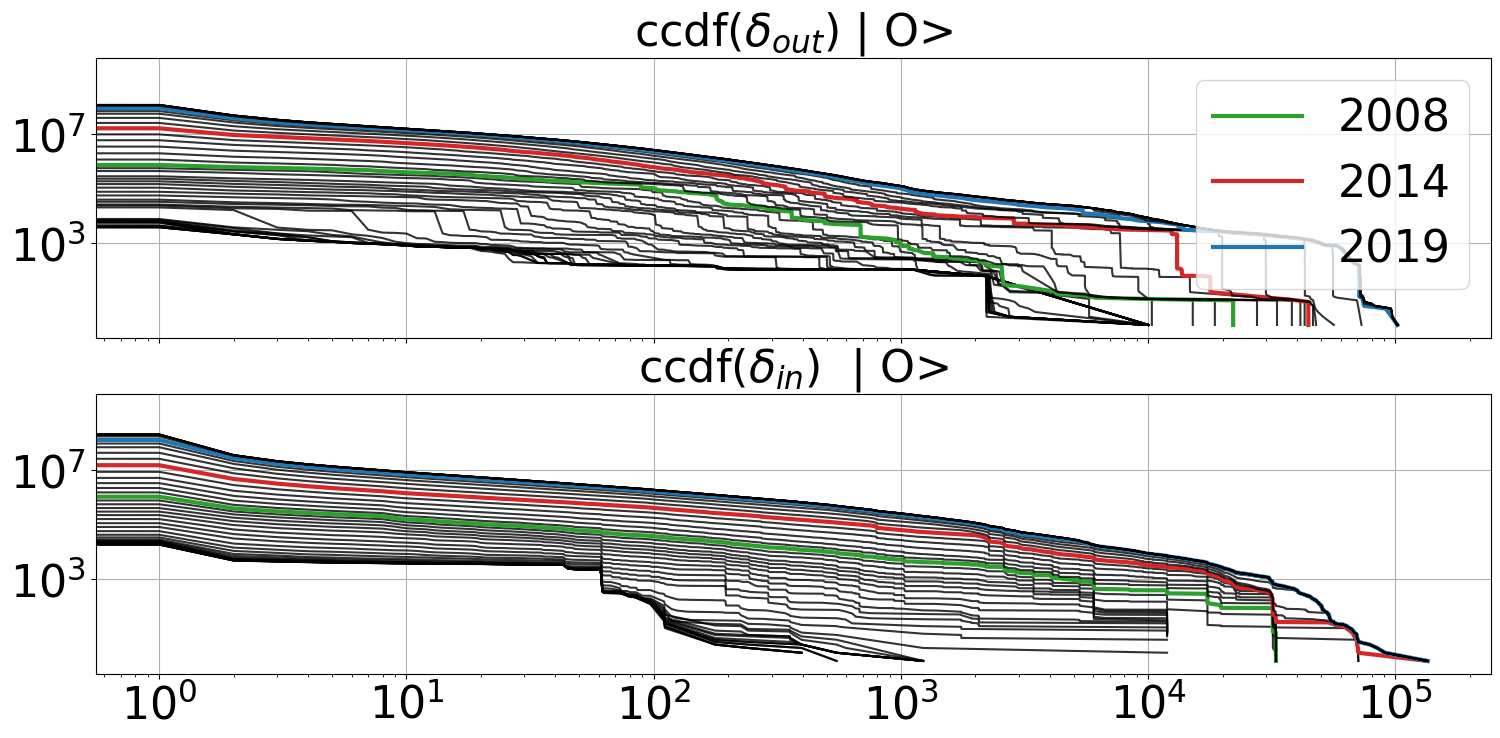

--------------------------------------------------------------------------------


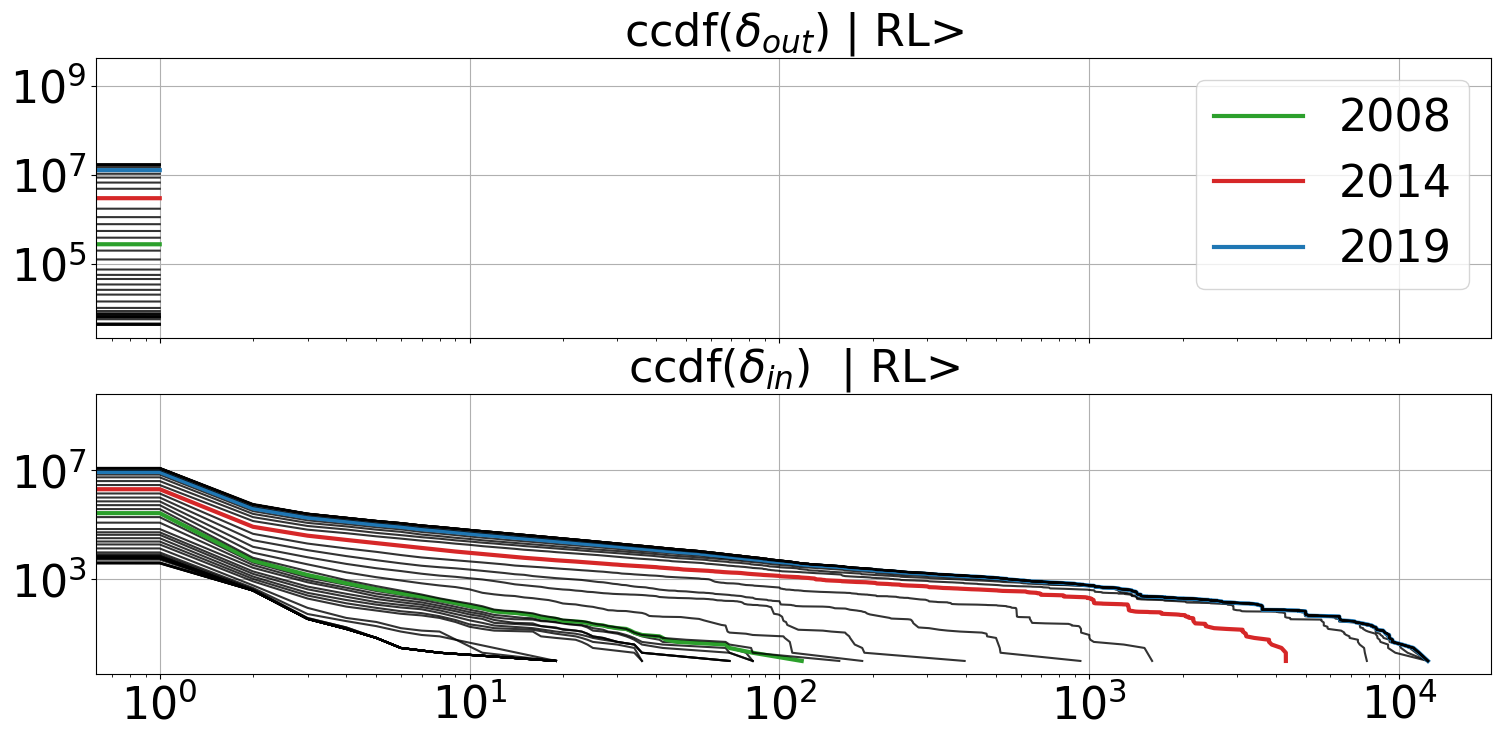

--------------------------------------------------------------------------------


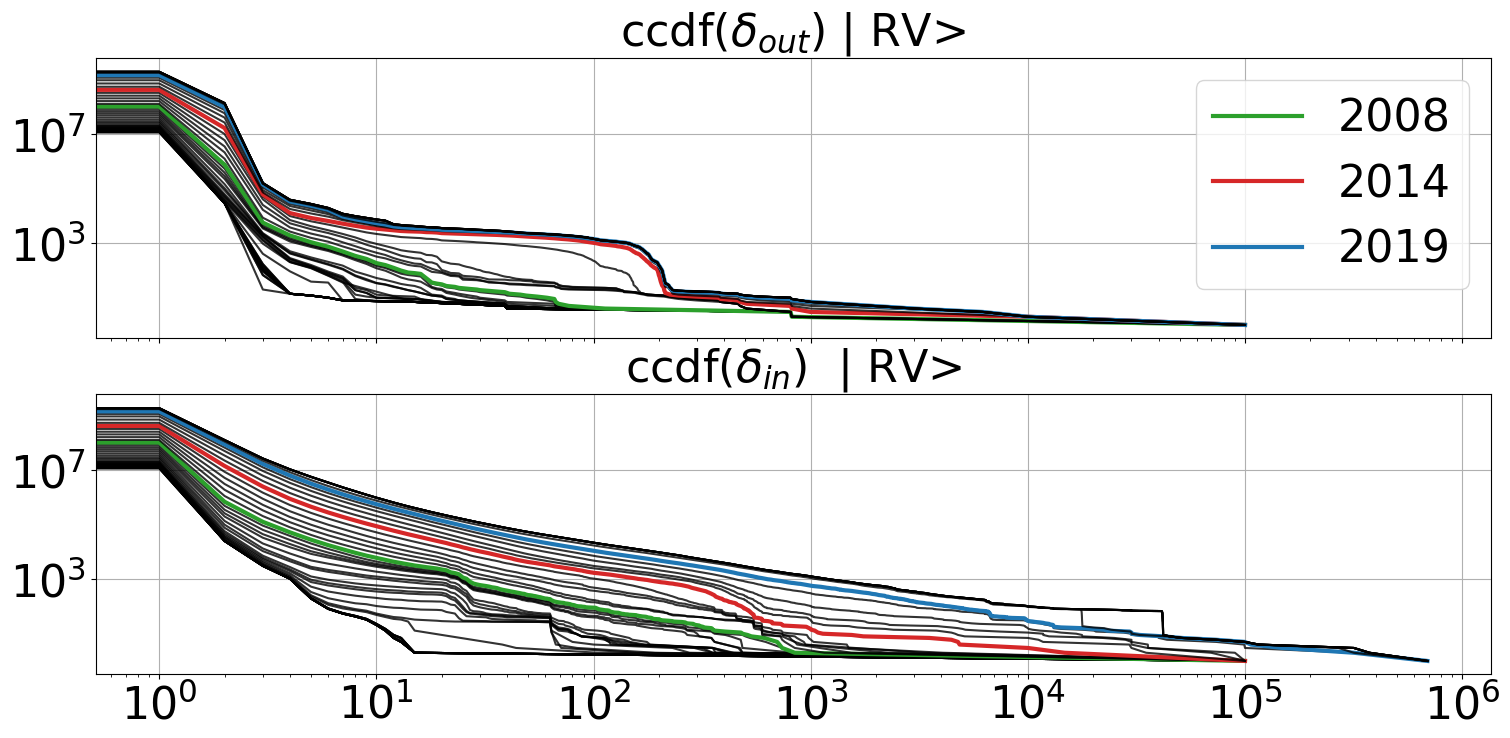

--------------------------------------------------------------------------------


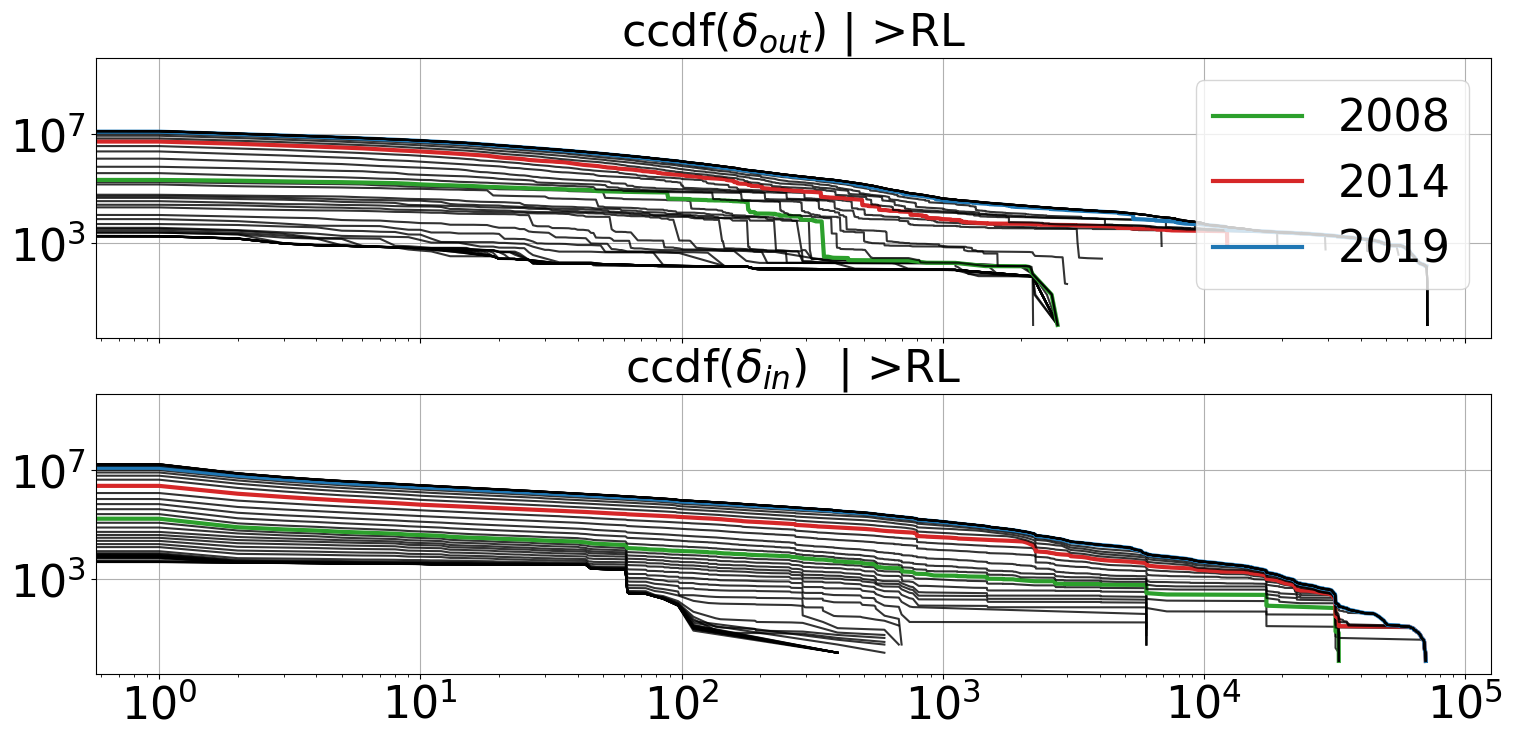

--------------------------------------------------------------------------------


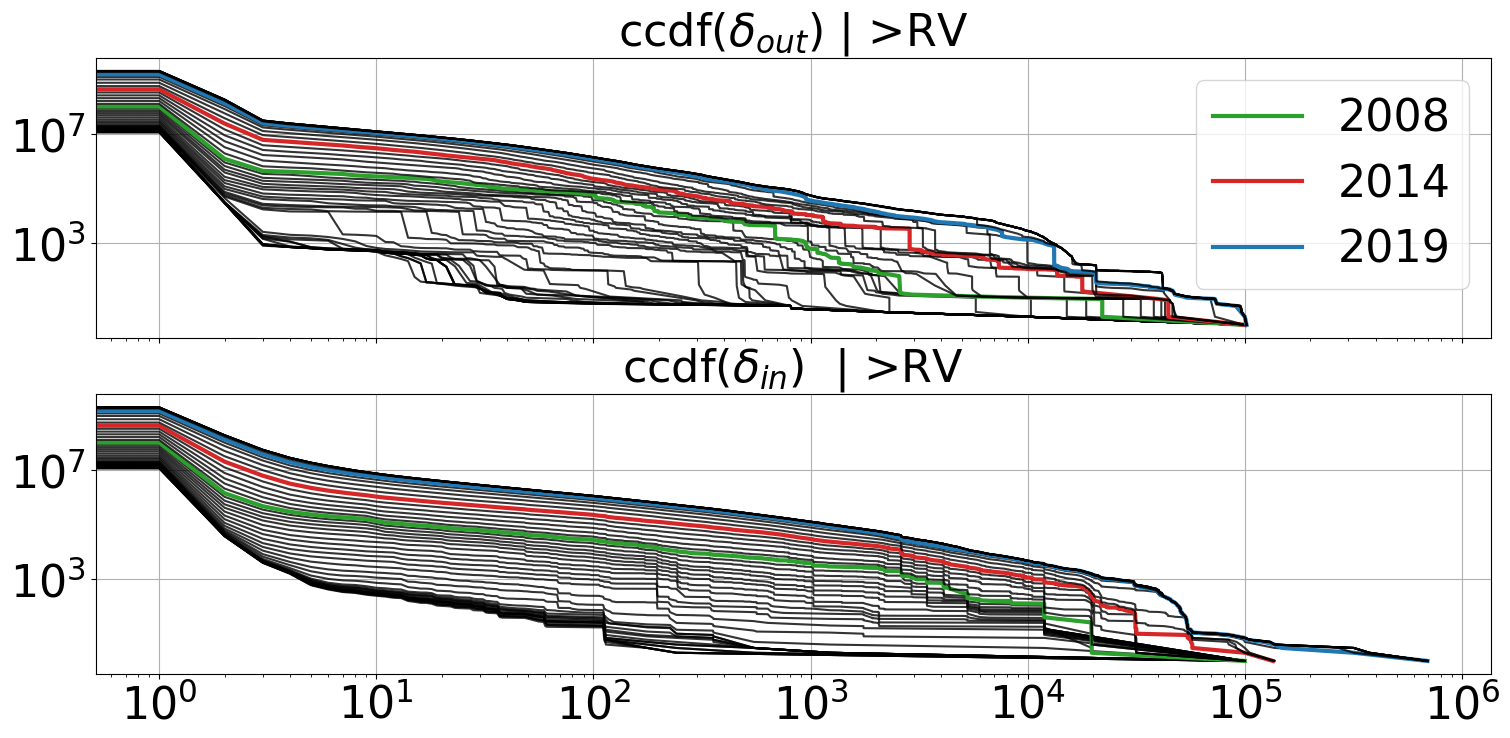

In [12]:
dout,din=pickle.load(open(exportpath+"degreeInOutHisto_year_1980_2025_"+version+".pkl","rb"))
print("dout.keys()",dout.keys())
print("din.keys() ",din.keys())
nfig=2
fontsize=FontSize[nfig]

# ccdf or df
if True:
    field,key=('ccdf',"ccdf")
else:
    field,key=('y',"df")


YearList=[2008,2014,2019]
ColorList=["tab:green","tab:red","tab:blue"]
for s in dout.keys():
    print("-"*80)
    #print(s)
    fig, axs = plt.subplots(nfig,figsize=(18,4*nfig),sharex=True)   
    #plt.tight_layout()
    for i in [0,1]:
        axs[i].grid()
        axs[i].set_yscale("log")
        axs[i].set_xscale("log")
        axs[i].tick_params(axis='both',which='major',labelsize=FontSize[nfig])
        
    for year in dout[s].keys():
        if year in YearList:
            c=ColorList[np.where(np.array(YearList)==year)[0][0]]
        
            axs[0].plot(dout[s][year]["x"],dout[s][year][key],markersize=0.5,c=c,lw=3,label=str(year))
            axs[1].plot(din[s][year]["x"],din[s][year][key],markersize=0.5,c=c,lw=3,label=str(year))

        else:
            axs[0].plot(dout[s][year]["x"],dout[s][year][key],markersize=0.5,c="k",alpha=0.8)
            axs[1].plot(din[s][year]["x"],din[s][year][key],markersize=0.5,c="k",alpha=0.8)
    axs[1].set_title(field+r'$(\delta_{in})$  | '+s,fontsize=fontsize)
    axs[0].set_title(field+r'$(\delta_{out})$ | '+s,fontsize=fontsize)
    axs[0].legend(loc='upper right',fontsize=fontsize,ncol=1,markerscale=2)
    plt.show()

## d) In the scope of this study

Focus on revision source node
- temporal evolution of indegree and out degree of $RV>RV$ edges
- convolution effect on indegree distribution of $R$ nodes.

### Temporal evolution of indegree and out degree of $RV>RV$ edges

Here, we implement two rules. The first, referred to as `TrueTime`, defines the creation date of an edge as the maximum of the timestamps associated with its source and target nodes; otherwise, the creation date defaults to the source node's timestamp.


In [14]:
Rebuild=False
Fsave=False
FTrueTime=True
version="20250524"

In [16]:
if Rebuild:
    dout={}
    din={}
if Rebuild :

    # permute edges to switch to True Ttime
    # can update timestamp and/or source/target
    # here only TrueTime (no permutation of source and target)
    if  FTrueTime:
        TSY=np.maximum(sourceTSY,targetTSY)
    else:
        TSY=sourceTSY
        
    GetAllTypesDegreeStats(sourceedges,edges,TSY,dout,din,Nnodes)    
    GetPerTypesDegreeStats(sourceedges,edges,TSY,Edgestype,Edgesencoding,dout,din,Nnodes,PerFlag="EDGE")   
    GetPerTypesDegreeStats(sourceedges,edges,TSY,Edgestype,Edgesencoding,dout,din,Nnodes,PerFlag="TARGET")   
    GetPerTypesDegreeStats(sourceedges,edges,TSY,Edgestype,Edgesencoding,dout,din,Nnodes,PerFlag="SOURCE")  
    if Fsave and FTrueTime:
        pickle.dump((dout,din),open(exportpath+"degreeInOutHisto_TT_year_1980_2025_"+version+".pkl","wb"))
    else:
        pickle.dump((dout,din),open(exportpath+"degreeInOutHisto_year_1980_2025_"+version+".pkl","wb"))

Start All types
1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
All types elapse :  1653.61 (s)
Start Per EDGE types 
Start type O>RL / 687,095,698 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type O>RV / 1,017,960,393 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RL>RL / 41,351 edges | 1980 1984 1988 1992 1996 2000 2012 2016 2020 2024 
Start type RL>RV / 17,225,899 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type RV>RV / 2,119,355,702 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Per edges types elapse :  4836.69 (s)
Start Per TARGET types 
Start type >RL / 687,137,049 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2020 2024 
Start type >RV / 3,154,541,994 edges | 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016 2024 
Per edges types elapse :  2464.21 (s)
Start Per SOURCE types 
Start type O> / 1,705,056,091 edges | 1980 1984 1988 1992 1996 2000 200

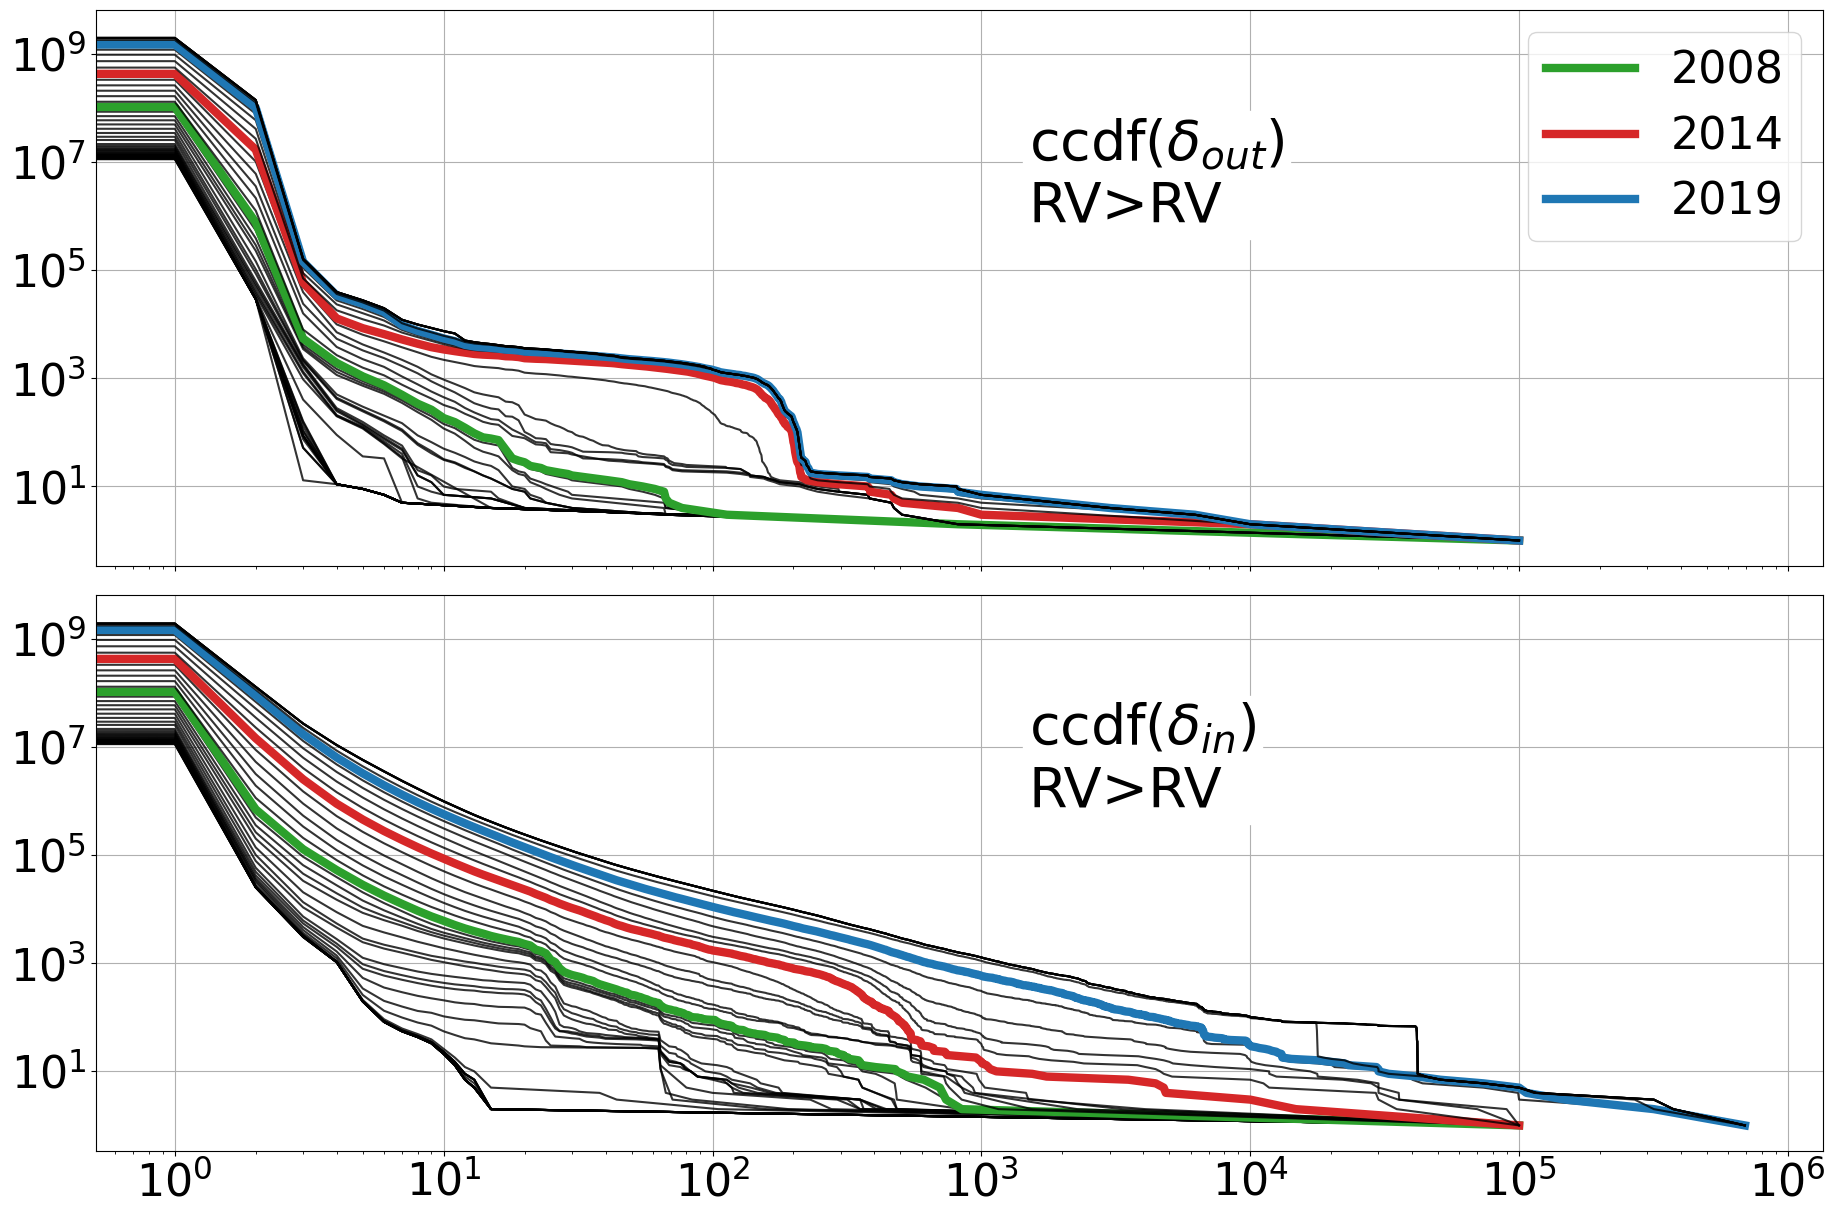

In [15]:
if FTrueTime:
    dout,din=pickle.load(open(exportpath+"degreeInOutHisto_TT_year_1980_2025_20240924.pkl","rb"))
else:
    dout,din=pickle.load(open(exportpath+"degreeInOutHisto_year_1980_2025_20240924.pkl","rb"))


# ccdf or df
if True:
    field,key=('ccdf',"ccdf")
else:
    field,key=('y',"df")
    
YearList=[2008,2014,2019]
ColorList=["tab:green","tab:red","tab:blue"]
nfig=2

    
fontsize=FontSize[nfig]


fig, axs = plt.subplots(nfig,figsize=(18,6*nfig),sharex=True)   
plt.tight_layout()
for s in ['RV>RV']:
    plt.tight_layout()
    for i in [0,1]:
        axs[i].grid()
        axs[i].set_yscale("log")
        axs[i].set_xscale("log")
        axs[i].tick_params(axis='both',which='major',labelsize=FontSize[nfig])

    for year in dout[s].keys():
        if year in YearList:
            c=ColorList[np.where(np.array(YearList)==year)[0][0]]
        
            axs[0].plot(dout[s][year]["x"],dout[s][year][key],markersize=0.5,c=c,lw=6,label=str(year))
            axs[1].plot(din[s][year]["x"],din[s][year][key],markersize=0.5,c=c,lw=6,label=str(year))

        else:
            axs[0].plot(dout[s][year]["x"],dout[s][year][key],markersize=0.5,c="k",alpha=0.8)
            axs[1].plot(din[s][year]["x"],din[s][year][key],markersize=0.5,c="k",alpha=0.8)
    axs[1].text(1.5e3,8e5,r'ccdf$(\delta_{in})$'+'\nRV>RV',fontdict={"fontsize":fontsize+8,'backgroundcolor':'w'})
    axs[0].text(1.5e3,8e5,r'ccdf$(\delta_{out})$'+'\nRV>RV',fontdict={"fontsize":fontsize+8,'backgroundcolor':'w'})
    axs[0].legend(loc='upper right',fontsize=fontsize,ncol=1,markerscale=2)
    plt.show()


### In-degree Distributions and Convolution Effects for target $RV$ nodes.


In [16]:
FTrueTime=True

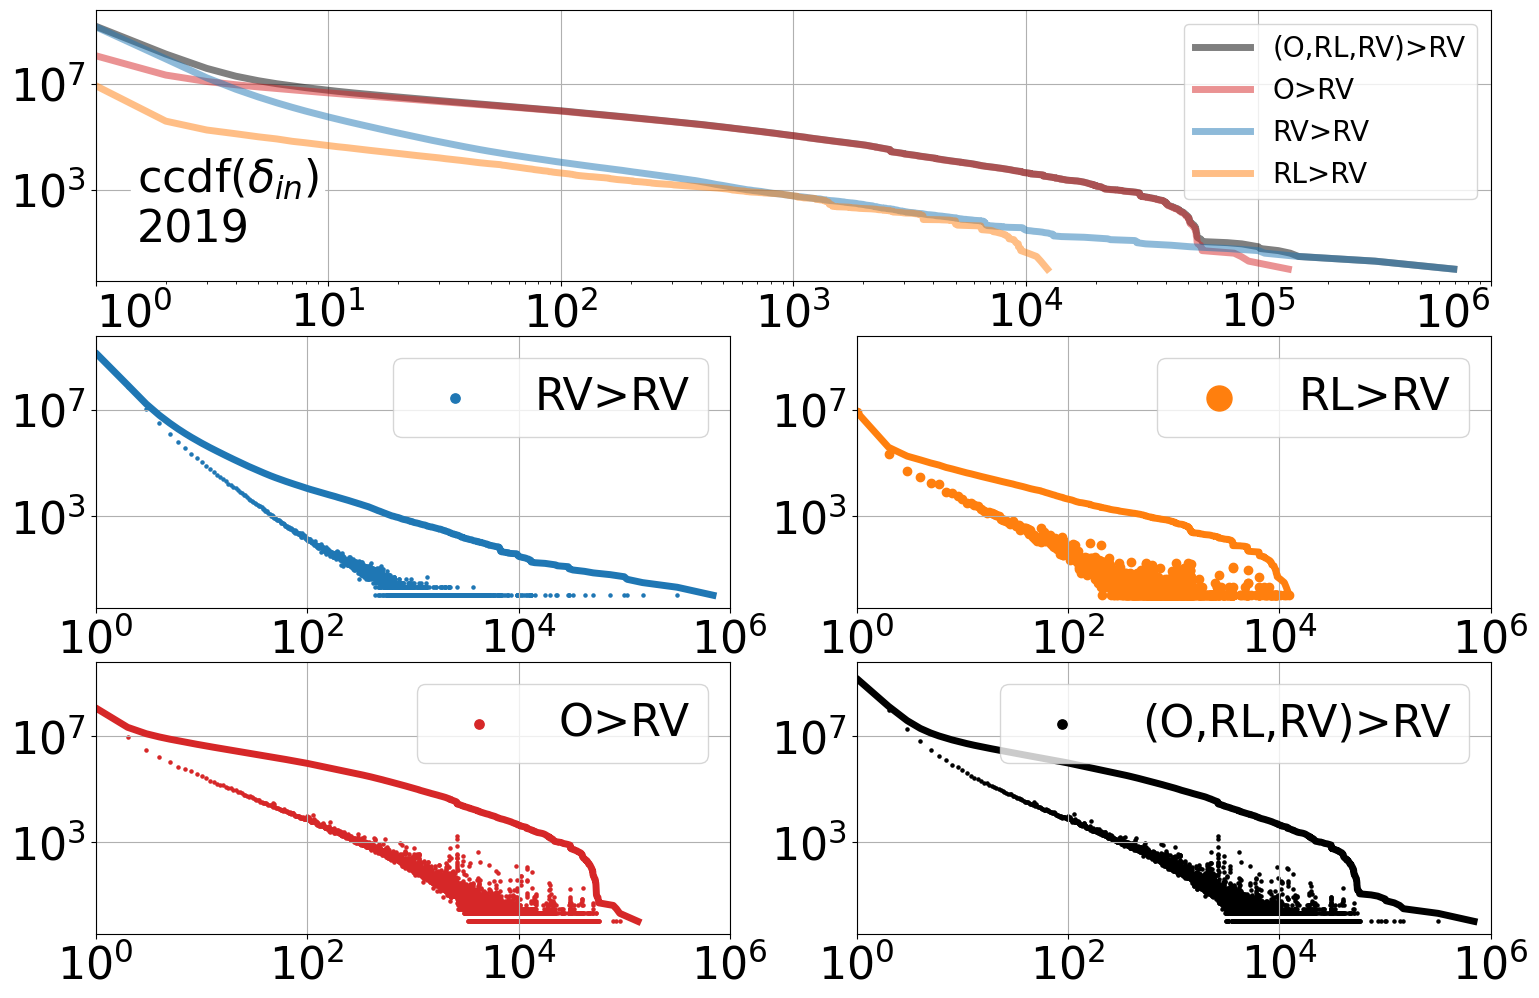

In [17]:
if FTrueTime:
    dout,din=pickle.load(open(exportpath+"degreeInOutHisto_TT_year_1980_2025_20240924.pkl","rb"))
else:
    dout,din=pickle.load(open(exportpath+"degreeInOutHisto_year_1980_2025_20240924.pkl","rb"))
dout
colortab={}
colortab["(O,RL,RV)>RV"]='k'
colortab["RV>RV"]='tab:blue'
colortab["O>RV"]='tab:red'
colortab["RL>RV"]='tab:orange'

dout["(O,RL,RV)>RV"]=dout[">RV"]
din["(O,RL,RV)>RV"]=din[">RV"]

plt.figure(figsize=(18,6*2))
plt.tight_layout()

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0))
ax3 = plt.subplot2grid((3, 2), (1, 1))
ax4 = plt.subplot2grid((3, 2), (2, 0))
ax5 = plt.subplot2grid((3, 2), (2, 1))

# 2018 => >=31/12/2018 == 1/1/2019
for year in [2019]:
    for indegreetype in ["(O,RL,RV)>RV","O>RV","RV>RV","RL>RV"]:
        ax1.plot(din[indegreetype][year]["x"],din[indegreetype][year]["ccdf"]
                 ,linewidth=5,color=colortab[indegreetype],label=indegreetype,alpha=0.5)
        if indegreetype=="RV>RV":
            ax2.scatter(din[indegreetype][year]["x"],din[indegreetype][year]["y"],s=5,color=colortab[indegreetype],label=indegreetype,alpha=1)
            ax2.plot(din[indegreetype][year]["x"],din[indegreetype][year]["ccdf"],lw=5,color=colortab[indegreetype])
            ax2.set_xlim(1,1e6)
            ax2.tick_params(axis='both',which='major',labelsize=fontsize)
            ax2.set_yscale("log")
            ax2.set_xscale("log")
            ax2.legend(fontsize=fontsize,loc="upper right",markerscale=3)
            ax2.grid()
        elif indegreetype=="RL>RV":
            ax3.scatter(din[indegreetype][year]["x"],din[indegreetype][year]["y"],color=colortab[indegreetype],label=indegreetype,alpha=1)
            ax3.plot(din[indegreetype][year]["x"],din[indegreetype][year]["ccdf"],lw=5,color=colortab[indegreetype])

            ax3.set_xlim(1,1e6)
            ax3.tick_params(axis='both',which='major',labelsize=fontsize)
            ax3.set_yscale("log")
            ax3.set_xscale("log")
            ax3.legend(fontsize=fontsize,loc="upper right",markerscale=3)
            ax3.grid()
        elif indegreetype=="O>RV":
            ax4.scatter(din[indegreetype][year]["x"],din[indegreetype][year]["y"],s=5,color=colortab[indegreetype],label=indegreetype,alpha=1)
            ax4.plot(din[indegreetype][year]["x"],din[indegreetype][year]["ccdf"],lw=5,color=colortab[indegreetype])
            ax4.set_xlim(1,1e6)
            #ax4.set_ylim(0.5,2e9)
            ax4.tick_params(axis='both',which='major',labelsize=fontsize)
            #ax4.set_yticks([])
            ax4.set_yscale("log")
            ax4.set_xscale("log")
            ax4.legend(fontsize=fontsize,loc="upper right",markerscale=3)
            ax4.grid()
        elif indegreetype=="(O,RL,RV)>RV":
            ax5.scatter(din[indegreetype][year]["x"],din[indegreetype][year]["y"],s=5,color=colortab[indegreetype],label=indegreetype,alpha=1)
            ax5.plot(din[indegreetype][year]["x"],din[indegreetype][year]["ccdf"],lw=5,color=colortab[indegreetype])
            ax5.set_xlim(1,1e6)
            ax5.tick_params(axis='both',which='major',labelsize=fontsize)
            ax5.set_yscale("log")
            ax5.set_xscale("log")
            ax5.legend(fontsize=fontsize,loc="upper right",markerscale=3)
            ax5.grid()

ax1.tick_params(axis='both',which='major',labelsize=fontsize)
ax1.set_xlim(1,1e6)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.legend(fontsize=fontsize-12,loc="upper right")
ax1.grid()
ax1.text(1.5e0,1e1,r'ccdf$(\delta_{in})$'+'\n2019',fontdict={"fontsize":fontsize,'backgroundcolor':'w'})

#axs=plt.gca()
for ax in [ax1]:
    xticklabels=ax.get_xticklabels()
    for i, label in enumerate(xticklabels):
        #print(i,label)
        if i == 0 or i == 1:  
                label.set_horizontalalignment('left')
        elif i == len(list(xticklabels)) - 1 or i == 7:  
                label.set_horizontalalignment('right')
        else:  
                label.set_horizontalalignment('center')

plt.show()

The top figure presents the complementary cumulative distribution function (CCDF) of the in-degree ($\delta_{in}$) for target revision nodes in the 2019 snapshot, disaggregated by the type of incoming edge. The bottom figures display, for each edge type individually, both the probability density function (PDF) and the corresponding CCDF.

The coexistence of multiple incoming edge types—originating from Origin ($O$), Revision ($RV$), and Release ($RL$) nodes—induces convolution effects in the aggregated distribution. These effects result in a smoother decay and an extended support in the overall in-degree distribution for edges of type $(O, RL, RV)>RV$ (shown in black).

A comparison of the individual distributions reveals that:
- The in-degree distribution for edges of type $O>RV$ dominates the aggregated distribution for degrees below approximately 60,000.
- The contribution of $RV>RV$ edges becomes visible only at higher in-degree values.
- The distribution of $RL>RV$ edges is not distinguishable in the aggregated distribution.

Independently of the question of whether the underlying variables are statistically independent—a point we do not elaborate on here—such convolution effects must be carefully considered when interpreting topological measures aggregated across (explicit or implicit) subtypes, as they can obscure distinct topological properties associated with specific edge types.
